## Batch Gradient Descent with early stopping for Softmax Regression
#### without using sklearn
#### Start by loading Iris dataset

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())

['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename']

In [3]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [4]:
X = iris['data'][:,(2,3)] # petal length and with
y = iris['target']

#### Add the bias term

In [5]:
X_with_bias = np.c_[np.ones([len(X), 1]), X]

#### set random seed

In [6]:
np.random.seed(9897)

#### Split dataset into train validation and test

In [7]:
test_ratio = 0.2
validation_ratio = 0.2
total_size = len(X_with_bias)

test_size = int(total_size * test_ratio)
validation_size = int(total_size * validation_ratio)
train_size = total_size - test_size - validation_size

rnd_indices = np.random.permutation(total_size)

X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]
X_valid = X_with_bias[rnd_indices[train_size:-validation_size]]
y_valid = y[rnd_indices[train_size:-validation_size]]
X_test = X_with_bias[rnd_indices[-validation_size:]]
y_test = y[rnd_indices[-validation_size:]]

#### The targets are 0,1 or 2. But we need we need target class probabilities to train SoftMax Regression. Target for one instance should look like [0.0, 0.0, 1].  
#### Small function to convert class indices into a matrix containing one-hot vector for each instance:

In [8]:
def to_one_hot(y):
    n_classes = y.max() + 1
    m = len(y)
    Y_one_hot = np.zeros((m, n_classes))
    dim = np.arange(m)
    Y_one_hot[dim, y] = 1
    return Y_one_hot

#### Create a target class probabilities matrix for train, test and validation sets

In [9]:
Y_train_one_hot = to_one_hot(y_train)
Y_test_one_hot = to_one_hot(y_test)
Y_valid_one_hot = to_one_hot(y_valid)

#### Implement SoftMax function

In [10]:
def softmax(logits):
    exps = np.exp(logits)
    exp_sums = np.sum(exps, axis=1, keepdims=True)
    return exps / exp_sums

#### Define # of inputs and outputs

In [11]:
n_inputs = X_train.shape[1] # == 3 (2 features + bias term)
n_outputs = len(np.unique(y_train)) # == 3 (3 iris classes)

In [12]:
eta = 0.01
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7

Theta = np.random.rand(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    error = Y_proba - Y_train_one_hot
    if iteration % 500 == 0:
        print(iteration, loss)
    gradients = 1/m * X_train.T.dot(error)
    Theta = Theta - eta * gradients

0 1.604583323758979
500 0.7579565971631109
1000 0.6295551441286501
1500 0.5534827866577033
2000 0.5031629007469917
2500 0.4669572752523552
3000 0.43928127723318355
3500 0.4171779636975023
4000 0.39894292666155307
4500 0.3835228622012723
5000 0.3702289808601775


#### Model is trained. Lets look at the parameters

In [13]:
Theta

array([[ 3.58395481, -0.42811976, -2.43206266],
       [-0.26734264,  0.87346011,  0.56066535],
       [-1.00105288,  0.18855706,  2.4487913 ]])

In [14]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.9

#### Add l2 regulaization.

In [15]:
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1 # regularization hyperparameter

Theta = np.random.rand(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    error = Y_proba - Y_train_one_hot
    if iteration % 500 == 0:
        print(iteration, loss)
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients

0 2.1518470043041047
500 0.5231772811968236
1000 0.49724425233163005
1500 0.4896595623966046
2000 0.4868134871518912
2500 0.4856472056339402
3000 0.48514757320441027
3500 0.4849280019826568
4000 0.48482999084256195
4500 0.4847858059392278
5000 0.4847657583438073


In [16]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.9666666666666667

#### Better score with regularization.
#### Add early stopping. For this we need to measure the loss on the validation setat every itteration and stop when the error starts growing.

In [17]:
eta = 0.1
n_iterations = 5001
m = len(X_train)
epsilon = 1e-7
alpha = 0.1 # regularization hyperparameter
best_loss = np.infty

Theta = np.random.rand(n_inputs, n_outputs)

for iteration in range(n_iterations):
    logits = X_train.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_train_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    error = Y_proba - Y_train_one_hot
    gradients = 1/m * X_train.T.dot(error) + np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]]
    Theta = Theta - eta * gradients
    
    logits = X_valid.dot(Theta)
    Y_proba = softmax(logits)
    xentropy_loss = -np.mean(np.sum(Y_valid_one_hot * np.log(Y_proba + epsilon), axis=1))
    l2_loss = 1/2 * np.sum(np.square(Theta[1:]))
    loss = xentropy_loss + alpha * l2_loss
    if iteration % 500 == 0:
        print(iteration, loss)
    if loss < best_loss:
        best_loss = loss
    else:
        print(iteration - 1, best_loss)
        print(iteration, loss, 'early stopping!')
        break

0 1.1875850960520558
500 0.601497900741713
1000 0.5823954689438321
1500 0.5758774787947037
2000 0.5733217679291949
2500 0.5722902626003422
3000 0.5718726750037704
3500 0.5717073375529986
4000 0.5716459085518774
4500 0.5716265110307899
4946 0.5716232418594672
4947 0.571623241861578 early stopping!


In [18]:
logits = X_valid.dot(Theta)
Y_proba = softmax(logits)
y_predict = np.argmax(Y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_valid)
accuracy_score

0.9666666666666667

#### Plot model predictions ont the whole dataset

In [19]:
import matplotlib.pyplot as plt

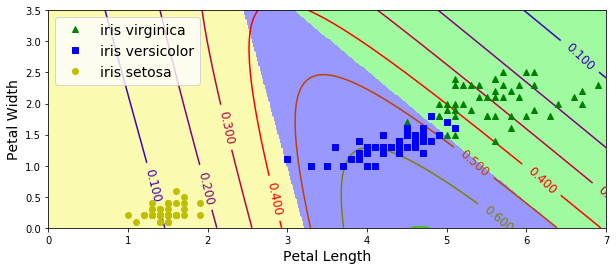

In [20]:
x0, x1 = np.meshgrid(
        np.linspace(0,8,500).reshape(-1, 1),
        np.linspace(0,3.5,200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new_with_bias = np.c_[np.ones([len(X_new), 1]), X_new]

logits = X_new_with_bias.dot(Theta)
y_proba = softmax(logits)
y_predict = np.argmax(y_proba, axis=1)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], 'g^', label='iris virginica')
plt.plot(X[y==1, 0], X[y==1, 1], 'bs', label='iris versicolor')
plt.plot(X[y==0, 0], X[y==0, 1], 'yo', label='iris setosa')

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel('Petal Length', fontsize=14)
plt.ylabel('Petal Width', fontsize=14)
plt.legend(loc='upper left', fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()

#### Measure the final model's accuracy on test set

In [21]:
logits = X_test.dot(Theta)
y_proba = softmax(logits)
y_predict = np.argmax(y_proba, axis=1)

accuracy_score = np.mean(y_predict == y_test)
accuracy_score

1.0

#### Better than on validation. This is due to the small size of the dataset.